In [ ]:
%matplotlib inline

# Feature Analysis with Yellowbrick

Feature analysis visualizers are designed to visualize instances in data space in order to detect features or targets that might impact downstream fitting. Because ML operates on high-dimensional data sets (usually several dozen!), the visualizers focus on aggregation, optimization, and other techniques to give overviews of the data. It is our intent that the steering process will allow the data scientist to zoom and filter and explore the relationships between their instances and between dimensions.

In [1]:
import os
import numpy as np
import pandas as pd
import yellowbrick as yb

## Load and Prepare the Data

  
!    
!    
!    
!    
!    
!    
!    
!    
First, go to your `select/data` folder, and unzip the zipped files!    
!    
!    
!    
!    
!    
!    
!    
!    
  

In [2]:
data = pd.read_csv("data/occupancy/datatraining.txt")
X = data[["Temperature", "Humidity", "Light", "CO2", "HumidityRatio"]].values
y = data["Occupancy"].values

## Look for separability

### Radviz

`RadViz` is a multivariate data visualization algorithm that plots each feature dimension uniformly around the circumference of a circle then plots points on the interior of the circle such that the point normalizes its values on the axes from the center to each arc. This mechanism allows as many dimensions as will easily fit on a circle, greatly expanding the dimensionality of the visualization.

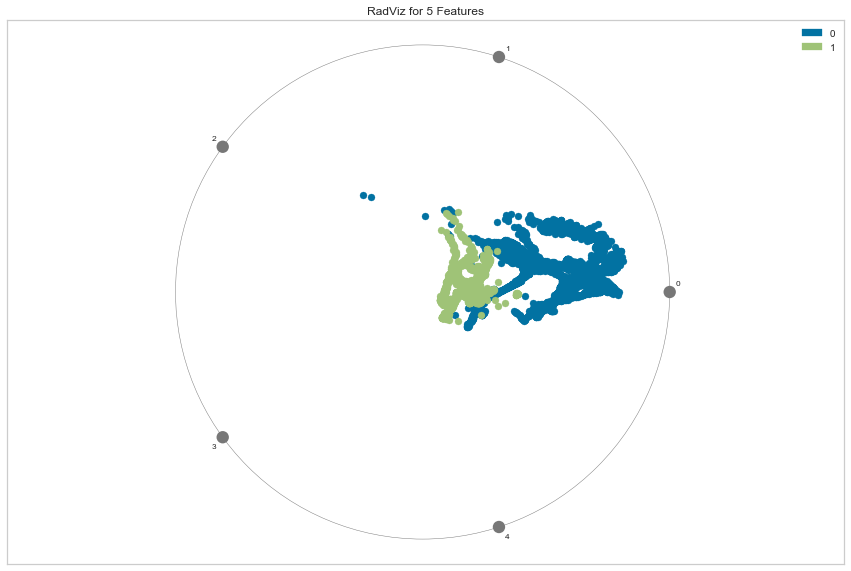

In [3]:
from yellowbrick.features import RadViz

# Specify the target classes
classes = ["unoccupied", "occupied"]

# Instantiate the visualizer
visualizer = RadViz(size=(1080, 720))

visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.poof()              # Draw/show/poof the data

Data scientists use this method to detect separability between classes. 

Is there an opportunity to learn from the feature set or is there just too much noise?

### Parallel Coordinates

Parallel coordinates is multi-dimensional feature visualization technique where the vertical axis is duplicated horizontally for each feature. Instances are displayed as a single line segment drawn from each vertical axes to the location representing their value for that feature. This allows many dimensions to be visualized at once; in fact given infinite horizontal space (e.g. a scrolling window), technically an infinite number of dimensions can be displayed!

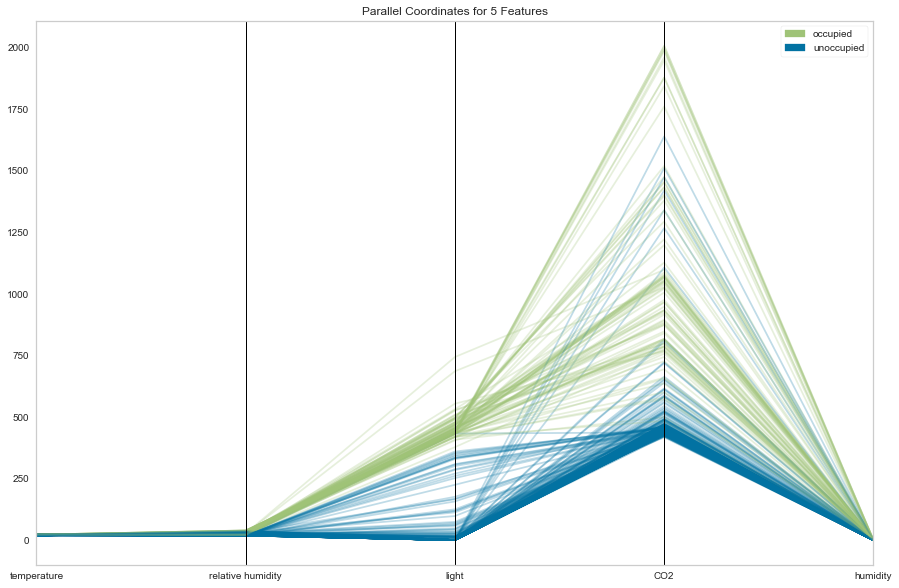

In [4]:
from yellowbrick.features import ParallelCoordinates

# Specify the features of interest and the classes of the target
features = [
    "temperature", "relative humidity", "light", "CO2", "humidity"
]
classes = ["unoccupied", "occupied"]

# Instantiate the visualizer
visualizer = ParallelCoordinates(
    classes=classes, features=features, sample=0.05, 
    shuffle=True, size=(1080, 720)
)

# Fit and transform the data to the visualizer
visualizer.fit(X, y)
visualizer.transform(X)

# Finalize the title and axes then display the visualization
visualizer.poof()

Data scientists use this method to detect clusters of instances that have similar classes, and to note features that have high variance or different distributions.

By inspecting the visualization closely, we can see that the combination of transparency and overlap gives us the sense of groups of similar instances, sometimes referred to as "braids". If there are distinct braids of different classes, it suggests that there is enough separability that a classification algorithm might be able to discern between each class.

However, as we inspect this class, we can see that the domain of each feature may make the visualization hard to interpret. In the above visualization, the domain of the `light` feature is from in `[0, 1600]`, far larger than the range of temperature in `[50, 96]`. To solve this problem, each feature should be scaled or normalized so they are approximately in the same domain.

Normalization techniques can be directly applied to the visualizer without pre-transforming the data (though you could also do this) by using the `normalize` parameter:

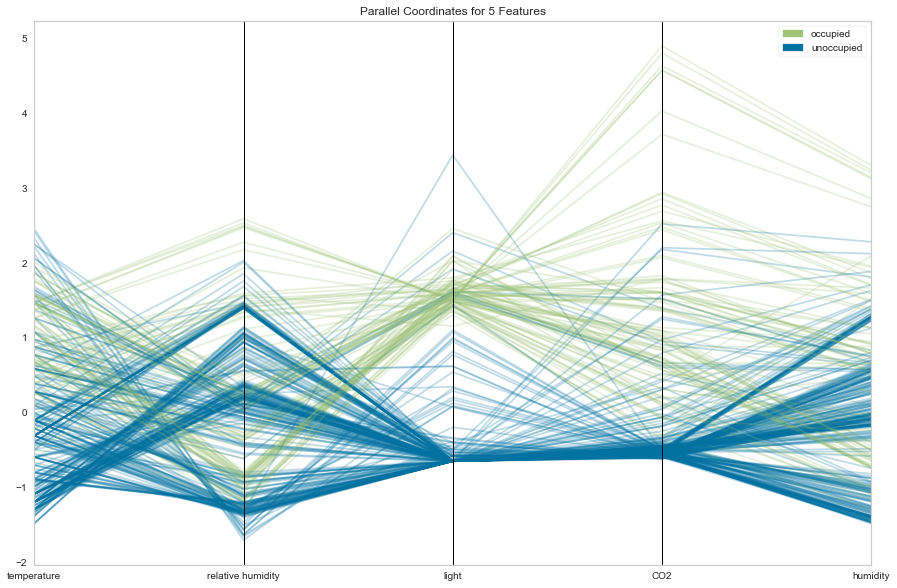

In [5]:
# Instantiate the visualizer
visualizer = ParallelCoordinates(
    classes=classes, features=features,
    normalize='standard', # This time we'll specify a normalizer
    sample=0.05, shuffle=True, size=(1080, 720)
)

# Fit the visualizer and display it
visualizer.fit(X, y)
visualizer.transform(X)

visualizer.poof()

Try using `minmax`, `minabs`, `standard`, `l1`, or `l2` normalization above to change perspectives!

## Look for correlations

### Feature Importances
The feature engineering process involves selecting the minimum required features to produce a valid model because the more features a model contains, the more complex it is (and the more sparse the data), therefore the more sensitive the model is to errors due to variance. A common approach to eliminating features is to describe their relative importance to a model, then eliminate weak features or combinations of features and re-evalute to see if the model fairs better during cross-validation.

Many model forms describe the underlying impact of features relative to each other. In scikit-learn, Decision Tree models and ensembles of trees such as Random Forest, Gradient Boosting, and Ada Boost provide a `feature_importances_` attribute when fitted. The Yellowbrick `FeatureImportances` visualizer utilizes this attribute to rank and plot relative importances.

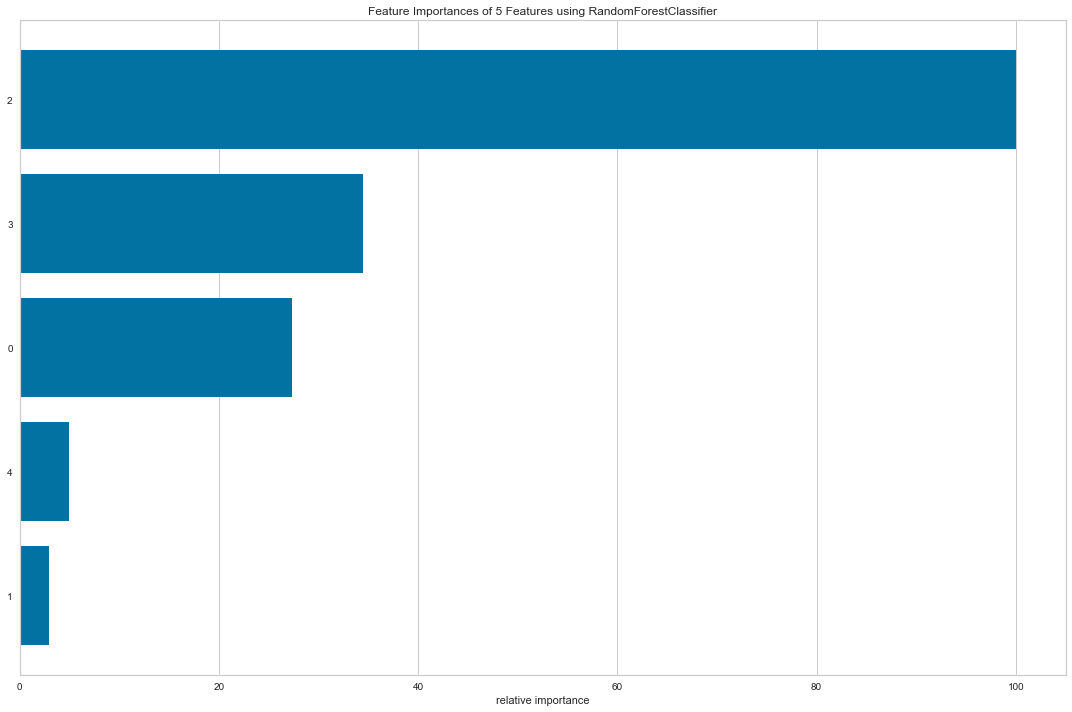

In [6]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.features import FeatureImportances

model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(model, size=(1080, 720))

viz.fit(X, y)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

The above figure shows the features ranked according to the explained variance each feature contributes to the model. In this case the features are plotted against their *relative importance*, that is the percent importance of the most important feature. The visualizer also contains `features_` and `feature_importances_` attributes to get the ranked numeric values.

For models that do not support a `feature_importances_` attribute, the `FeatureImportances` visualizer will also draw a bar plot for the `coef_` attribute that many linear models provide.

When using a model with a `coef_` attribute, it is better to set `relative=False` to draw the true magnitude of the coefficient (which may be negative). We can also specify our own set of labels if the dataset does not have column names or to print better titles.

### Rank 2D

A two-dimensional ranking of features utilizes a ranking algorithm that takes into account pairs of features at a time (e.g. joint plot analysis). The pairs of features are then ranked by score and visualized using the lower left triangle of a feature co-occurence matrix.

First let's load a new dataset to work with:

In [7]:
data = pd.read_excel("data/credit.xls", header=1)

X = data[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].values
y = data['default payment next month'].values

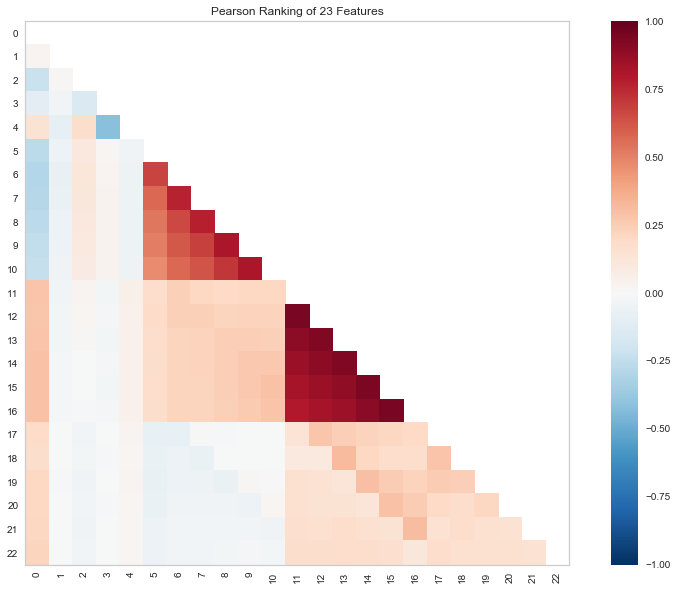

In [8]:
from yellowbrick.features import Rank2D

# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson', size=(1080, 720))

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.poof()

By default, the `Rank2D` visualizer utilizes the Pearson correlation score to detect colinear relationships.

Alternatively, we can utilize the covariance ranking algorithm, which attempts to compute the mean value of the product of deviations of variates from their respective means. Covariance loosely attempts to detect a colinear relationship between features. Try substituting `algorithm='covariance'` above to see the difference!

## Look at the distribution


### PCA Projection

The PCA Decomposition visualizer utilizes principal component analysis to decompose high dimensional data into two or three dimensions so that each instance can be plotted in a scatter plot. The use of PCA means that the projected dataset can be analyzed along axes of principal variation and can be interpreted to determine if spherical distance metrics can be utilized.

/Users/franco/anaconda3/envs/ta/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/franco/anaconda3/envs/ta/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/franco/anaconda3/envs/ta/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


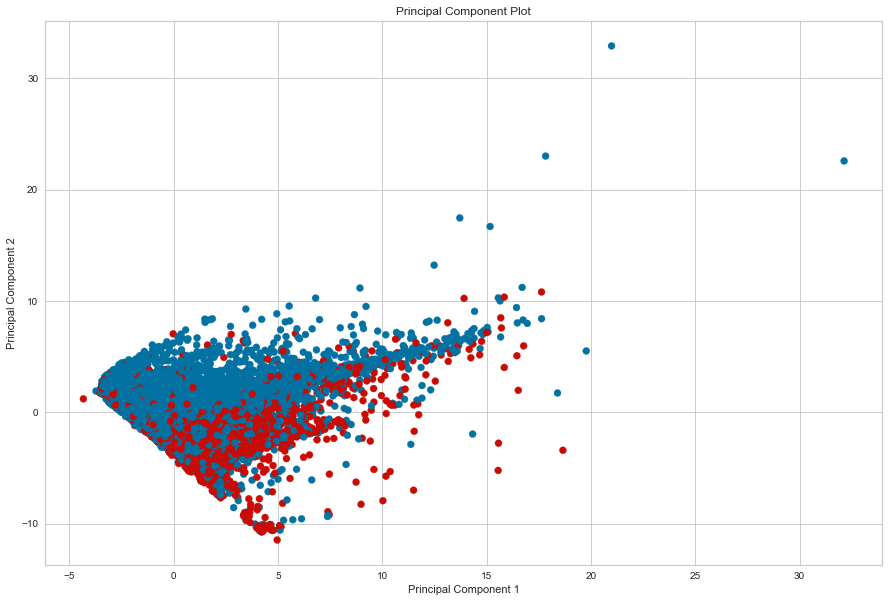

In [9]:
from yellowbrick.features.pca import PCADecomposition

# Create a list of colors to assign to points in the plot
colors = np.array(['r' if yi else 'b' for yi in y])

visualizer = PCADecomposition(
    scale=True, color=colors, size=(1080, 720)
)
visualizer.fit(X, y)
visualizer.transform(X)
visualizer.poof()

The PCA projection can also be plotted in three dimensions to attempt to visualize more principal components and get a better sense of the distribution in high dimensions. Try substituting in `visualizer = PCADecomposition(scale=True, color=colors, proj_dim=3)` above to see!

### Manifold

The `Manifold` visualizer provides high dimensional visualization using [manifold learning](https://scikit-learn.org/stable/modules/manifold.html) to embed instances described by many dimensions into 2, thus allowing the creation of a scatter plot that shows latent structures in data. Unlike decomposition methods such as PCA and SVD, manifolds generally use nearest-neighbors approaches to embedding, allowing them to capture non-linear structures that would be otherwise lost. The projections that are produced can then be analyzed for noise or separability to determine if it is possible to create a decision space in the data.

Let's load the concrete data:

In [10]:
data = pd.read_excel("data/concrete.xls", header=0)

X = data[['Cement (component 1)(kg in a m^3 mixture)',
       'Blast Furnace Slag (component 2)(kg in a m^3 mixture)',
       'Fly Ash (component 3)(kg in a m^3 mixture)',
       'Water  (component 4)(kg in a m^3 mixture)',
       'Superplasticizer (component 5)(kg in a m^3 mixture)',
       'Coarse Aggregate  (component 6)(kg in a m^3 mixture)',
       'Fine Aggregate (component 7)(kg in a m^3 mixture)', 'Age (day)']].values
y = data['Concrete compressive strength(MPa, megapascals) '].values

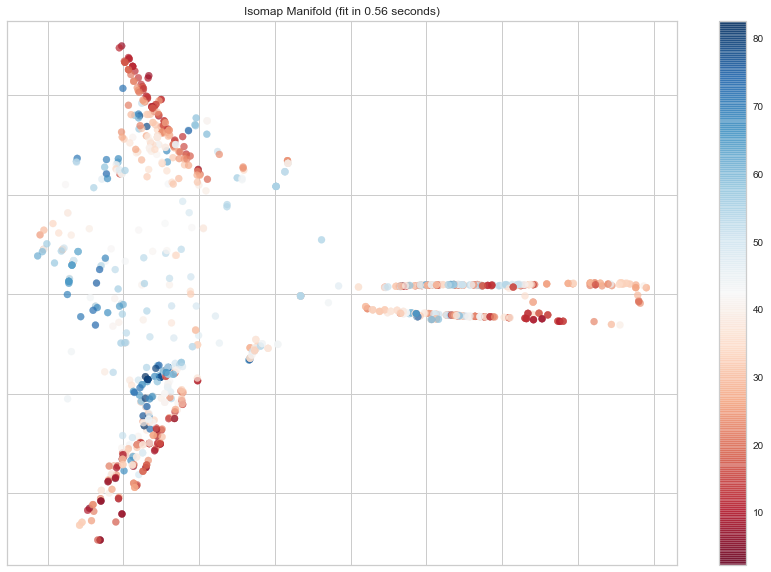

In [11]:
from yellowbrick.features.manifold import Manifold

visualizer = Manifold(
    manifold='isomap', target='continuous', size=(1080, 720)
)
visualizer.fit(X, y)
visualizer.transform(X)
visualizer.poof()

### Stochastic Neighbor Embedding

One very popular method for visualizing document similarity is to use t-distributed stochastic neighbor embedding, t-SNE. Scikit-learn implements this decomposition method as the `sklearn.manifold.TSNE` transformer. By decomposing high-dimensional document vectors into 2 dimensions using probability distributions from both the original dimensionality and the decomposed dimensionality, t-SNE is able to effectively cluster similar documents. By decomposing to 2 or 3 dimensions, the documents can be visualized with a scatter plot.

Unfortunately, TSNE is very expensive, so typically a simpler decomposition method such as SVD or PCA is applied ahead of time. The `TSNEVisualizer` creates an inner transformer pipeline that applies such a decomposition first (SVD with 50 components by default), then performs the t-SNE embedding. The visualizer then plots the scatter plot, coloring by cluster or by class, or neither if a structural analysis is required.

Let's load the hobbies corpus:

In [12]:
from sklearn.datasets.base import Bunch

## The path to the test data sets
FIXTURES  = os.path.join(os.getcwd(), "data")

def load_hobbies():
    """
    Loads and wrangles the passed in text corpus by name.
    """
    # Get the path from the datasets 
    path = os.path.join(FIXTURES, "hobbies")
    
    # Read the directories in the directory as the categories. 
    categories = [
        cat for cat in os.listdir(path) 
        if os.path.isdir(os.path.join(path, cat))
    ]
    
    files  = [] # holds the file names relative to the root 
    data   = [] # holds the text read from the file 
    target = [] # holds the string of the category 
        
    # Load the data from the files in the corpus 
    for cat in categories:
        for name in os.listdir(os.path.join(path, cat)):
            files.append(os.path.join(path, cat, name))
            target.append(cat)
            
            with open(os.path.join(path, cat, name), 'r', encoding = 'utf-8') as f:
                data.append(f.read())
        
    # Return the data bunch for use similar to the newsgroups example
    return Bunch(
        categories=categories,
        files=files,
        data=data,
        target=target,
    )

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

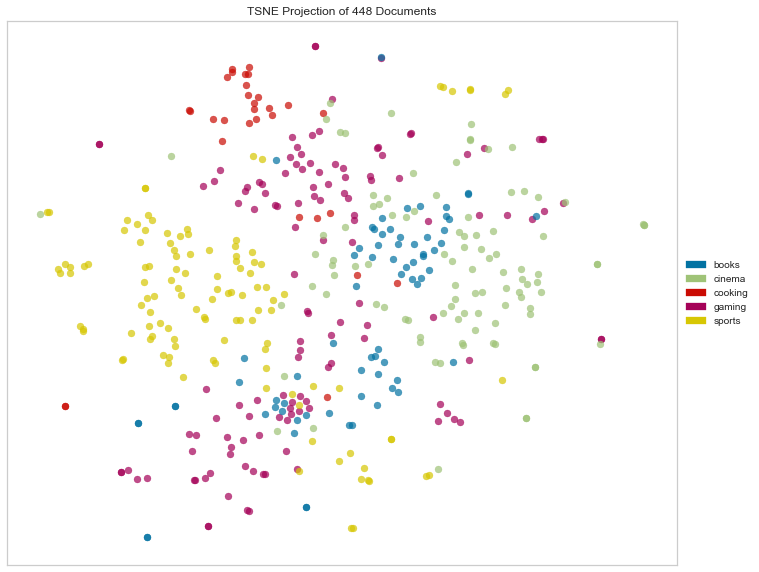

In [13]:
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the hobbies corpus (don't need to do again, included for completeness)
corpus = load_hobbies() 

tfidf = TfidfVectorizer()

docs = tfidf.fit_transform(corpus.data)
labels = corpus.target

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer(size=(1080, 720))
tsne.fit(docs, labels)
# Note: TSNE is a model visualizer not a feature visualizer, 
# so it has no transform method!
tsne.poof()

### Token Frequency

One method for visualizing the frequency of tokens within and across corpora is frequency distribution. A frequency distribution tells us the frequency of each vocabulary item in the text. In general, it could count any kind of observable event. It is a distribution because it tells us how the total number of word tokens in the text are distributed across the vocabulary items.

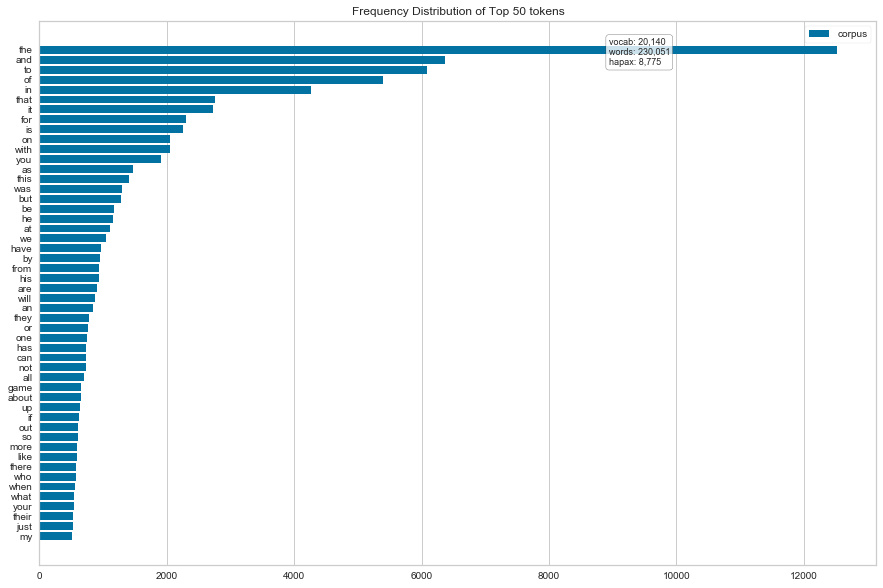

In [14]:
from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

docs = vectorizer.fit_transform(corpus.data)
features = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=features, size=(1080, 720))
visualizer.fit(docs)
# Note: FreqDistVisualizer is technically a model visualizer not a 
# feature visualizer, so it has no transform method!
visualizer.poof()

Read more about Yellowbrick's feature analysis tools [here](http://www.scikit-yb.org/en/latest/api/features/index.html)